In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')
#속도를 위해 추가
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import tensorflow
import summa
import pandas as pd
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


라이브러리 불러오기,확인
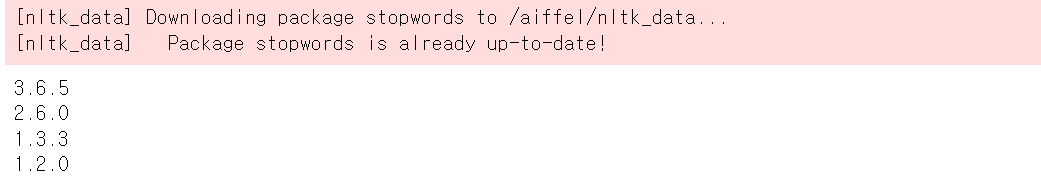

In [2]:
# Step 1. 데이터 수집하기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
82289,Reporters Committee slams Trump over CNN punch...,Reporters Committee for Freedom of the Press h...
98026,Federer releases music video with boyband #Bac...,Tennis player Roger Federer has released a mus...
64548,Which were the most polluted cities in India o...,Rajasthan's Bhiwadi was the most polluted city...
77963,Punjab AAP MLA booked for assaulting woman,Punjab Aam Aadmi Party MLA Amarjit Singh Sando...
85725,No solution to terror without coordinated effo...,Prime Minister Narendra Modi said it was not p...
25123,17 dead as boat ferrying tourists sinks in US,At least 17 people have died and seven others ...
83315,"Oracle, Getty support $1.2 billion fine agains...",Seven US companies including Oracle and Getty ...
78364,Telangana plans to rent jails to states with c...,"Telangana prisons department, citing Norway's ..."
42896,Abhishek Bachchan's look from comeback film Ma...,Actor Abhishek Bachchan's look from his comeba...
55727,Govt school students in Bhopal made to serve t...,Students from a government school in Bhopal we...


데이터 확인
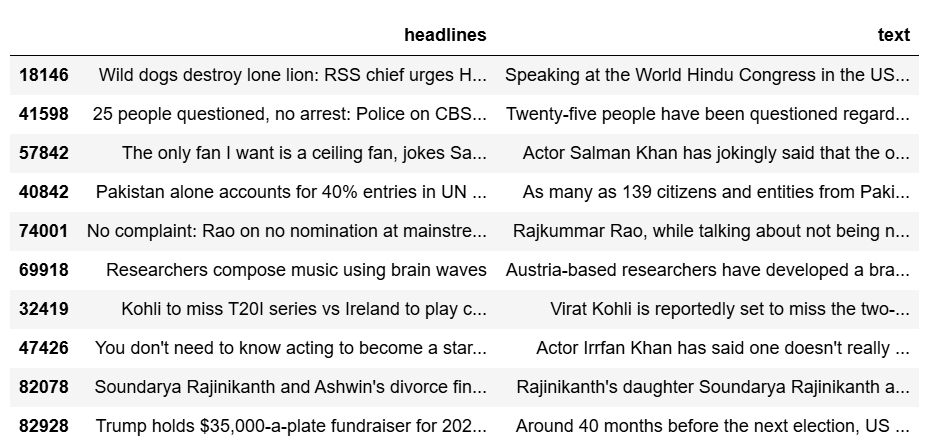

In [4]:
# 필요한 컬럼만 선택
data = data[['headlines', 'text']]

# 데이터 샘플 확인
print(data.head())
print("\n랜덤 샘플 15개:")
print(data.sample(15))


                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  

랜덤 샘플 15개:
                                               headlines  \
58449  Cancer drug seen to reduce HIV cells in patien...   
14390  My production house will encourage women to sp...   
31214  20-year-old Pant breaks Gambhir's 10-year-old ...   
14094  Karate teacher rapes 3-yr-old girl in Patna sc...   
44421  Kristen Wiig t

원하는 데이터를 받고 확인
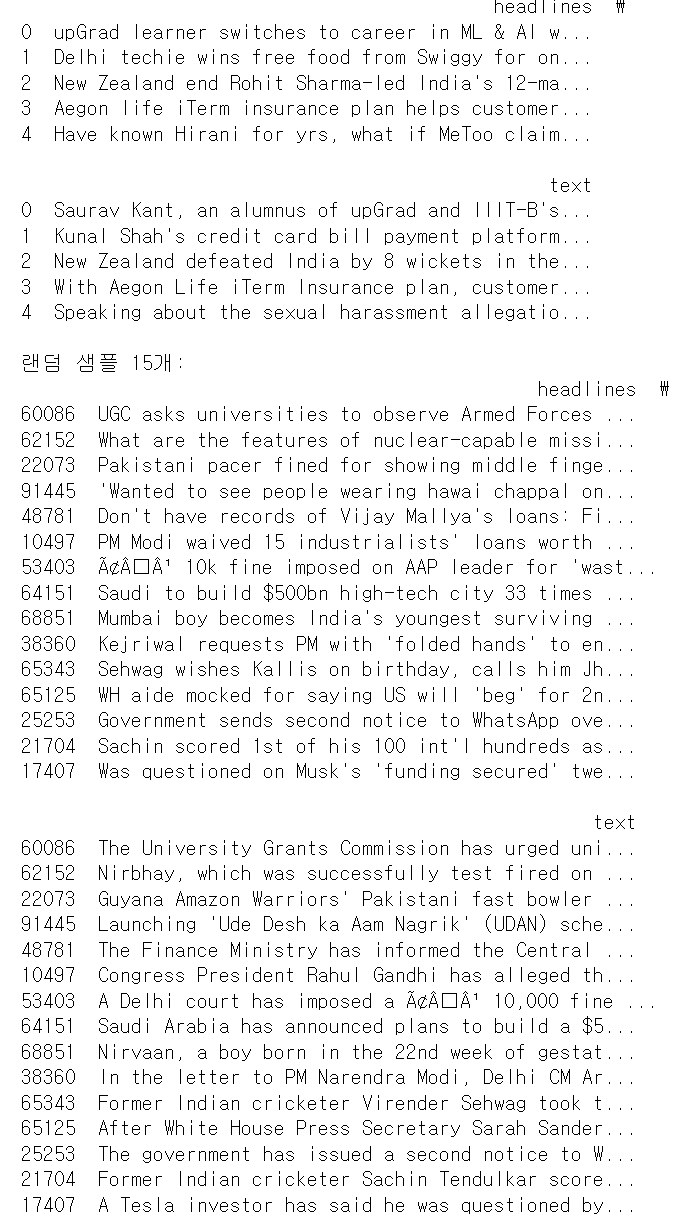

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


중복 확인
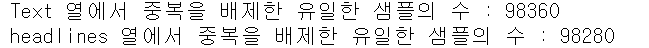

In [6]:
# Step 2. 데이터 전처리하기 (추상적 요약)
# 중복/결측치 제거
data.drop_duplicates(subset=['text'], inplace=True)
data.dropna(axis=0, inplace=True)
#인덱스 재정렬
data.reset_index(drop=True, inplace=True)
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


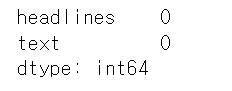

In [7]:
#정규화 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


정규화 사전 정의
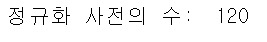

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

불용어 확인
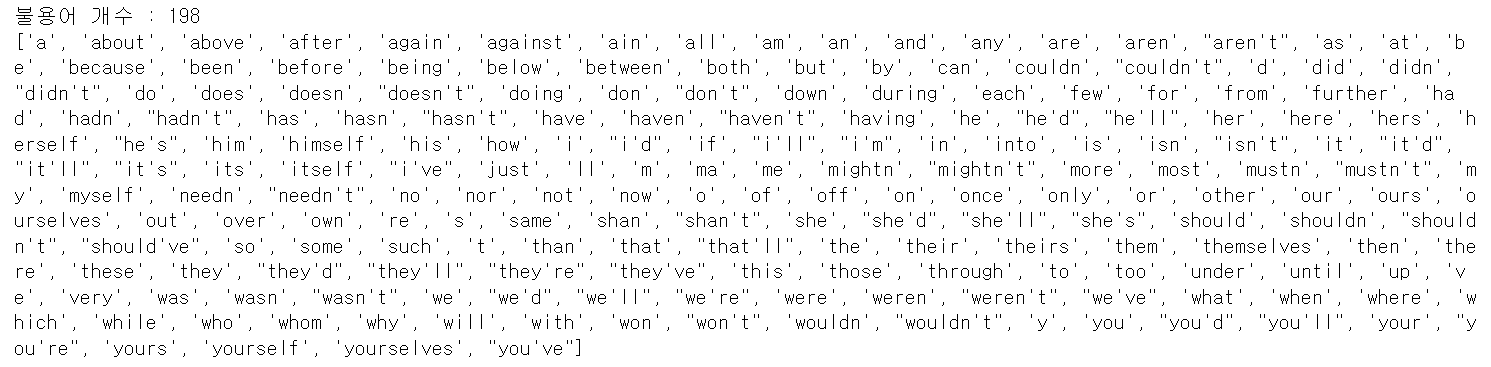

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [10]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

clean_text = [preprocess_sentence(x) for x in data['text']]

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

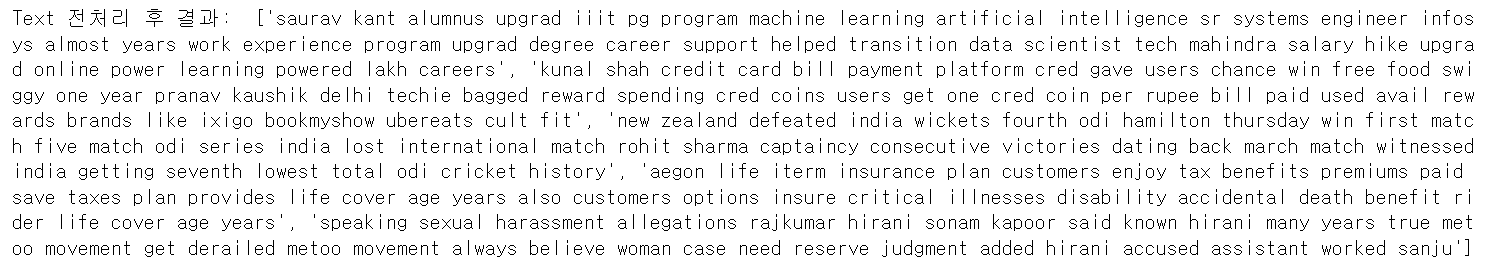

In [11]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

clean_headlines = [preprocess_sentence(x, False) for x in data['headlines']]

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


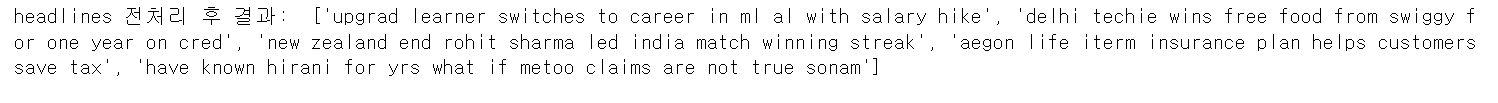
너무 오래걸려서 lms에서도 해보니 정상작동해서 기다리니까 됐다.1시간넘게 걸린 것 같다
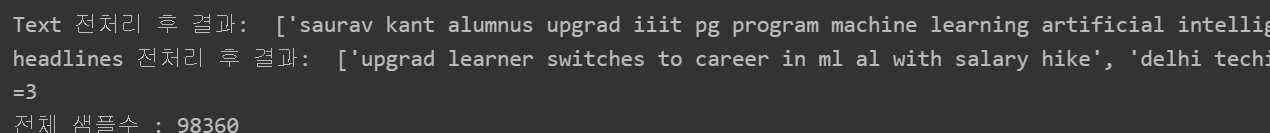

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

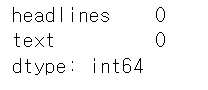

In [14]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


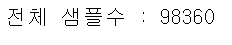

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


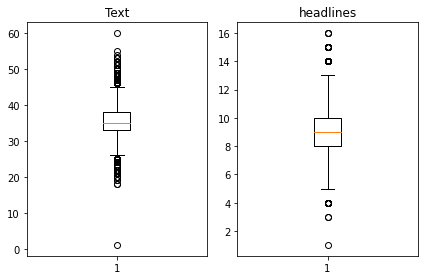

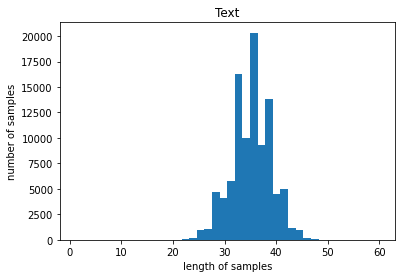

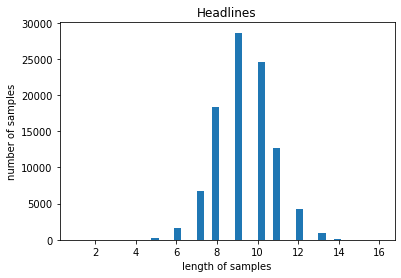

In [16]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

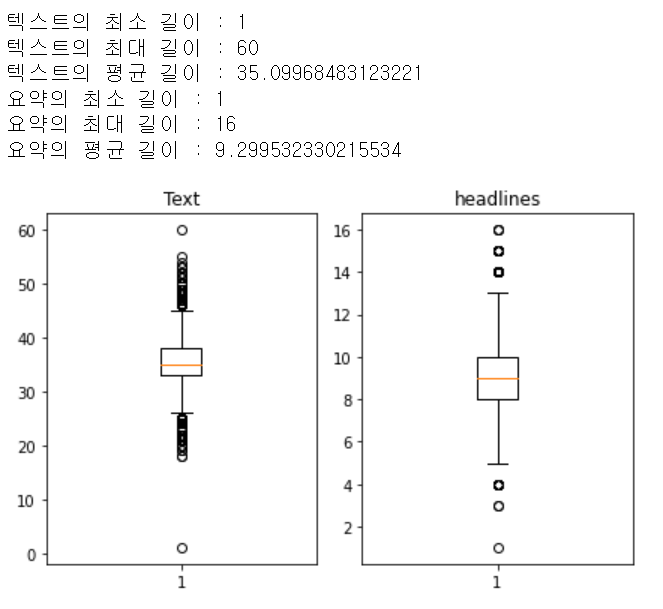
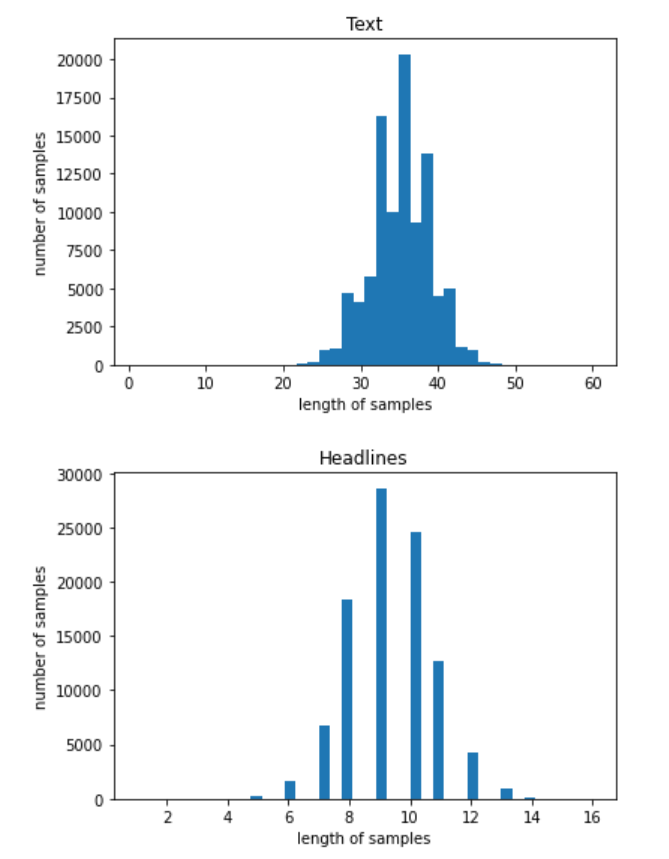

In [17]:
# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
text_max_len = 50
headlines_max_len = 8
print('=3')

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')


=3
=3


In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

data = data[
    (data['text'].apply(lambda x: len(x.split())) <= text_max_len) &
    (data['headlines'].apply(lambda x: len(x.split())) <= headlines_max_len)
]

print('전체 샘플수 :', (len(data)))

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142
전체 샘플수 : 27105


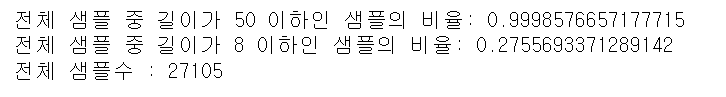

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')


=3


/tmp/ipykernel_84/444381235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
/tmp/ipykernel_84/444381235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')


In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[12682 23310 18230 ... 22266  2471 18779]
=3
테스트 데이터의 수 : 5421
훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


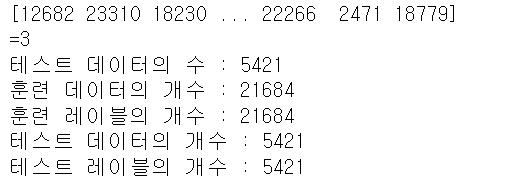

In [21]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3
단어 집합(vocabulary)의 크기 : 42440
등장 빈도가 6번 이하인 희귀 단어의 수: 30708
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11732
단어 집합에서 희귀 단어의 비율: 72.35626767200753
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.292686135227571
=3


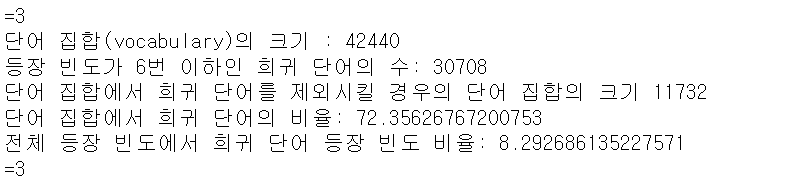

In [22]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

[[3, 645, 4787, 6503, 1309, 2980, 87, 5, 1119, 442, 3516, 1, 4635, 3, 4787, 472, 2721, 5, 3375, 2783, 410, 1361, 5, 3, 17, 275, 2981, 7432, 6769, 1025, 5, 133, 6], [103, 4265, 3143, 100, 358, 394, 256, 160, 4265, 608, 1669, 80, 2, 27, 363, 1421, 3143, 606, 3143, 211, 256, 82, 160, 37, 375, 1670, 1437, 256], [55, 17, 2, 27, 1903, 5573, 67, 548, 2, 27, 1543, 239, 3771, 66, 66, 1036, 865, 1838, 203, 5989, 723, 2316, 17, 680, 4636, 3949, 585, 1838, 417, 246, 695, 568, 1319]]
=3
단어 집합(vocabulary)의 크기 : 18861
등장 빈도가 5번 이하인 희귀 단어의 수: 14204
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4657
단어 집합에서 희귀 단어의 비율: 75.30883834367212
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.07949207438708
input
input  [[1, 8, 570, 5, 15], [1, 82, 365, 6, 13, 327], [1, 26, 501, 990, 515, 4, 317], [1, 459, 304, 84, 35, 16, 1824], [1, 242, 183, 1632, 1216, 3, 94]]
target
decoder  [[8, 570, 5, 15, 2], [82, 365, 6, 13, 327, 2], [26, 501, 990, 515, 4, 317, 2], [459, 304, 84, 35, 16, 1824, 2], [242, 183, 1632, 1216, 3, 94, 2]]


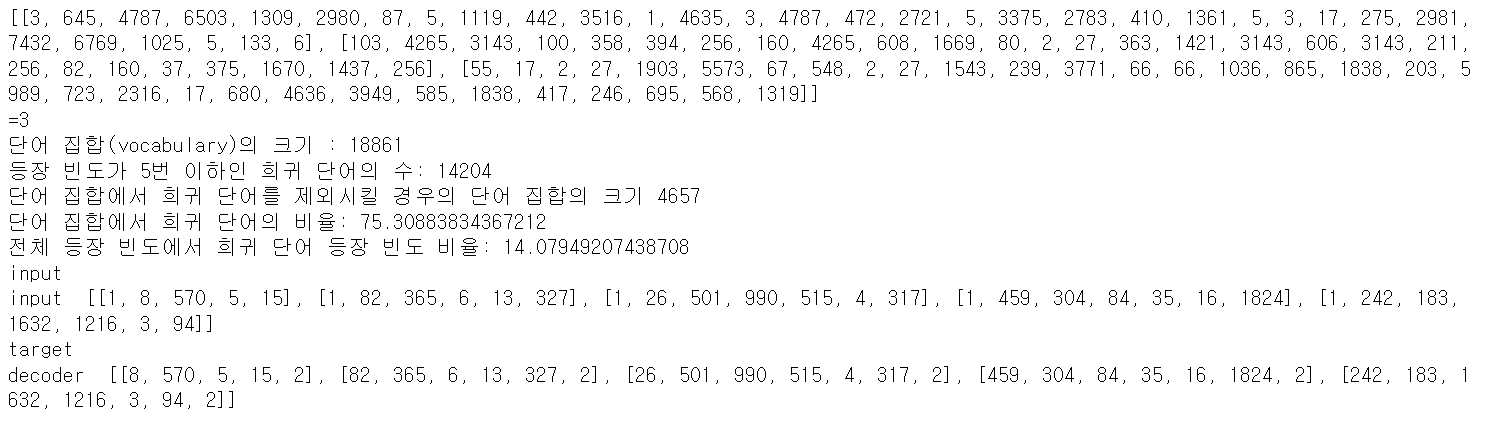

In [23]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

삭제할 훈련 데이터의 개수 : 6
삭제할 테스트 데이터의 개수 : 5
훈련 데이터의 개수 : 21678
훈련 레이블의 개수 : 21678
테스트 데이터의 개수 : 5416
테스트 레이블의 개수 : 5416
=3


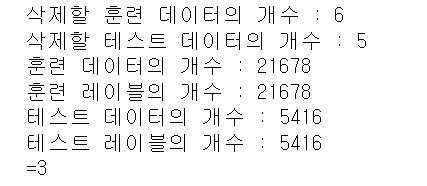

In [24]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [25]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

첫번째 모델
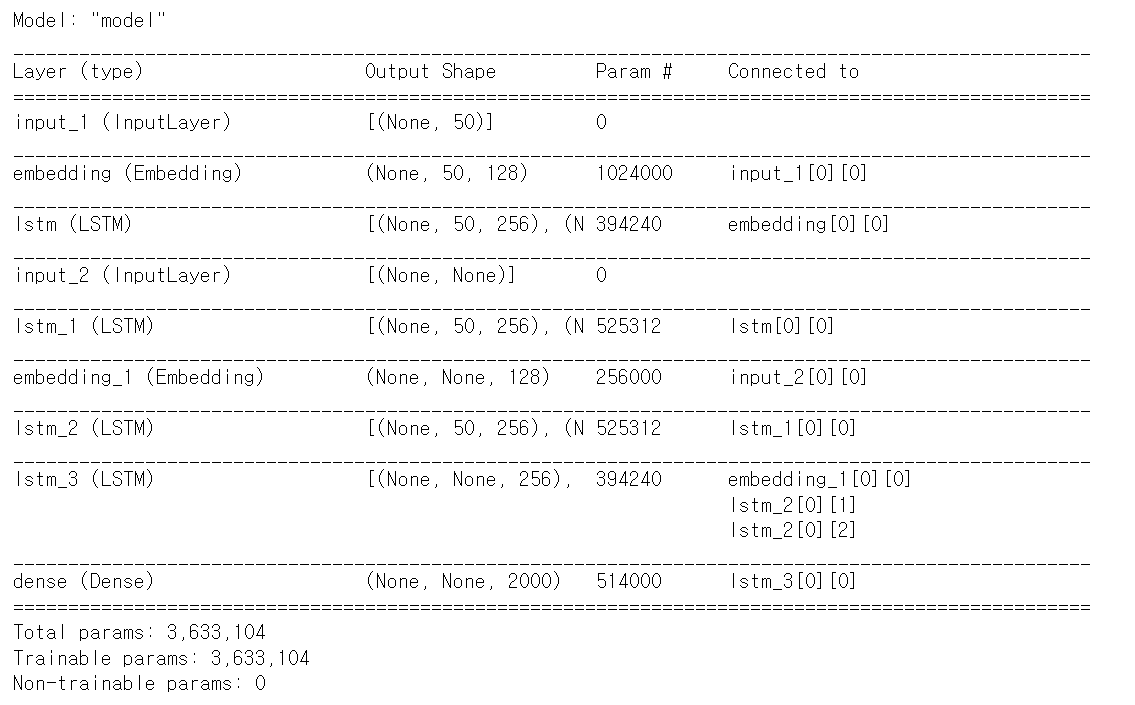
두번쨰 모델
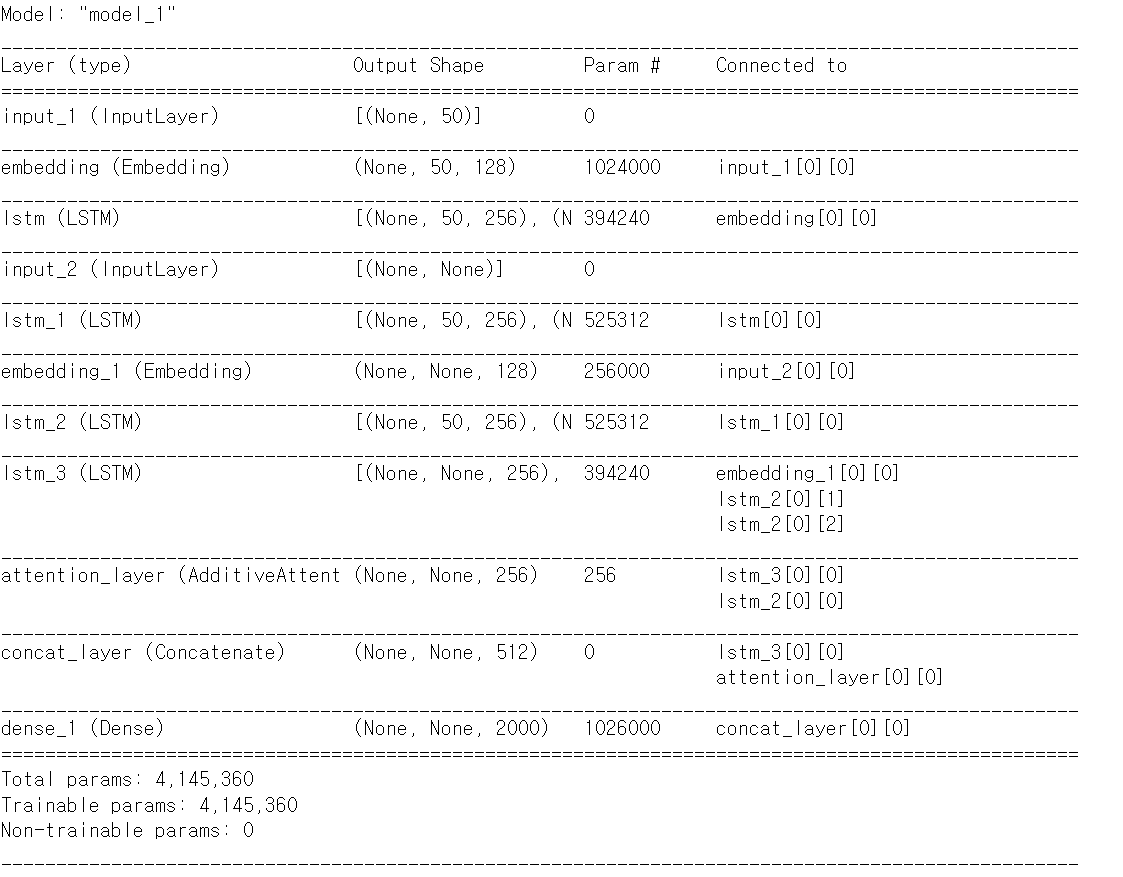

Epoch 1/50
85/85 [==============================] - 58s 80ms/step - loss: 4.9311 - val_loss: 4.4947
Epoch 2/50
85/85 [==============================] - 6s 65ms/step - loss: 4.5377 - val_loss: 4.3265
Epoch 3/50
85/85 [==============================] - 6s 66ms/step - loss: 4.3587 - val_loss: 4.1692
Epoch 4/50
85/85 [==============================] - 6s 66ms/step - loss: 4.1798 - val_loss: 4.0350
Epoch 5/50
85/85 [==============================] - 6s 67ms/step - loss: 4.0218 - val_loss: 3.9350
Epoch 6/50
85/85 [==============================] - 6s 67ms/step - loss: 3.8771 - val_loss: 3.7898
Epoch 7/50
85/85 [==============================] - 6s 67ms/step - loss: 3.7330 - val_loss: 3.7125
Epoch 8/50
85/85 [==============================] - 6s 68ms/step - loss: 3.6106 - val_loss: 3.6276
Epoch 9/50
85/85 [==============================] - 6s 68ms/step - loss: 3.5018 - val_loss: 3.5730
Epoch 10/50
85/85 [==============================] - 6s 69ms/step - loss: 3.3983 - val_loss: 3.5197
Epoch 11

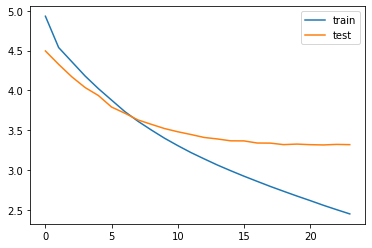

In [26]:
# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)
#결과 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

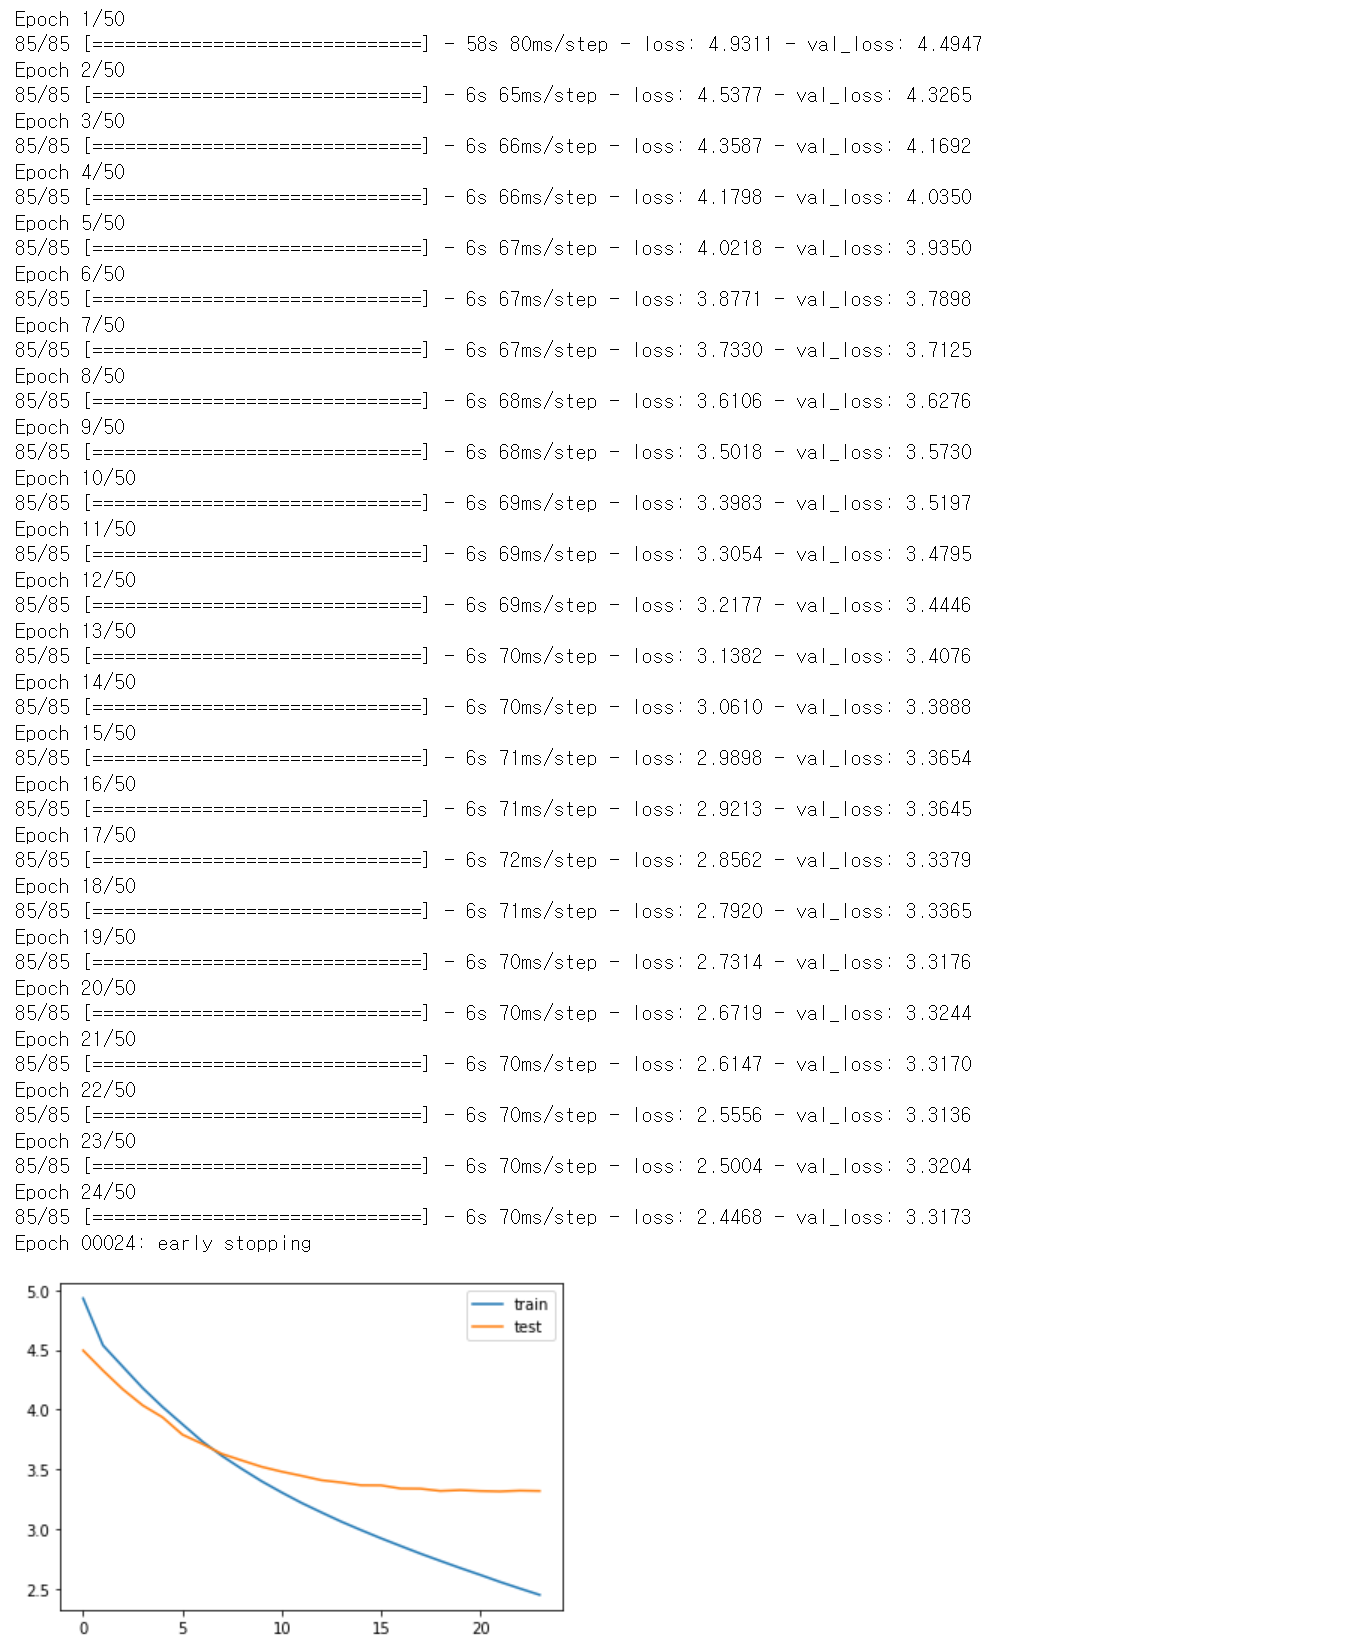

In [27]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3
=3
=3
=3


In [28]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if (i!=0 and i != tar_word_to_index['sostoken'] and i != tar_word_to_index['eostoken']):
            temp += tar_index_to_word[i] + ' '  # 타겟 사전 사용
    return temp.strip()

print('=3')

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

=3
원문 : madhya pradesh cabinet tuesday imposed ban using carry bags state effect may cows eat plastic bags leads death banning use protect lives besides plastic bags also harmful environment state public relations department minister mishra said 
실제 요약 : madhya pradesh bans from may
예측 요약 :  kerala bans in public


원문 : sports teacher part pune school good touch bad touch programme aimed raising awareness sexual harassment arrested allegedly molesting four students school said police charged sexually assaulting four class boys several occasions past five months produced court today 
실제 요약 : good bad teacher held
예측 요약 :  iit class professor for sexual assault


원문 : sized radar instrument capable human helping disaster relief workers mexico finding people trapped magnitude earthquake hit country last week earthquake prompted several killed people technology used make difference nasa officials said 
실제 요약 : nasa helps find mexico
예측 요약 :  us military to build in us


원문 : president pran

너무 많아 일부분만 캡처
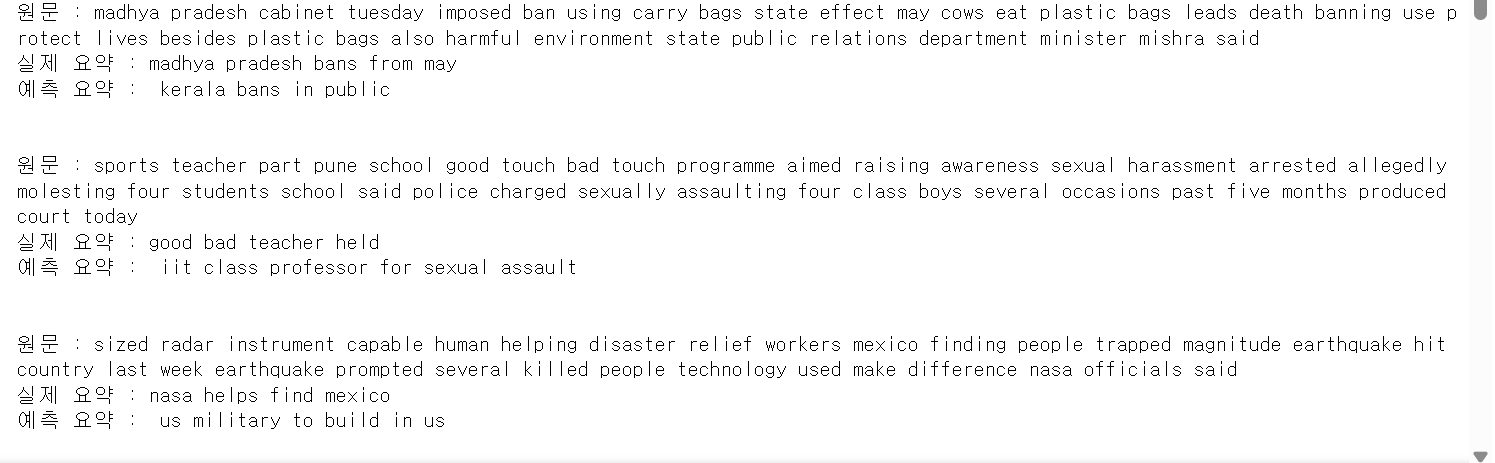

In [29]:
# Step 5. Summa을 이용해서 추출적 요약해보기
from summa.summarizer import summarize
import os
home = os.getenv('HOME')
path = os.path.join(home, 'data', 'The_matrix_synopsis.txt')
with open(path, encoding = 'UTF-8') as f:
    text = f.read()
    
print('headlines:')
print(summarize(text, ratio=0.005))
print('headlines:')
print(summarize(text, ratio=0.005, split=True))
print('headlines:')
print(summarize(text, words=50))

headlines:

headlines:
[]
headlines:
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


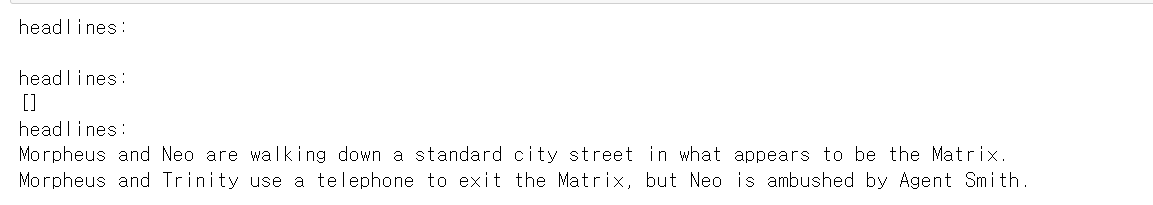

In [31]:
# 추출적 요약 함수
def extractive_summary(text):
    return summarize(text, ratio=0.2)

for i in range(5):
    sample_text = data['text'].iloc[i]
    print(f"\n원문 {i+1}: {sample_text[:200]}...")
    print("추출적 요약:", extractive_summary(sample_text))


원문 1: union minister dharmendra pradhan wednesday claimed illegal mining mafia odisha operates control cm naveen patnaik state congress chief niranjan patnaik added time come people odisha put full stop act...
추출적 요약: 

원문 2: indian space research organisation wednesday unveiled human space flight centre bengaluru crore manned space mission gaganyaan scheduled isro said centre responsible development engineering systems cr...
추출적 요약: 

원문 3: least people killed others injured saudi arabia week due flooding heavy rain emergency services rescued people flooded areas half tabuk heavy rains hit mainly western northwestern parts saudi arabia n...
추출적 요약: 

원문 4: investigators searching lost plane carrying argentine forward emiliano sala found two seat cushions french coast likely belonged aircraft investigators said launch underwater seabed search aircraft wr...
추출적 요약: 

원문 5: agustawestland chopper scam co accused rajiv saxena extradited india uae wednesday evading enforcement directorat

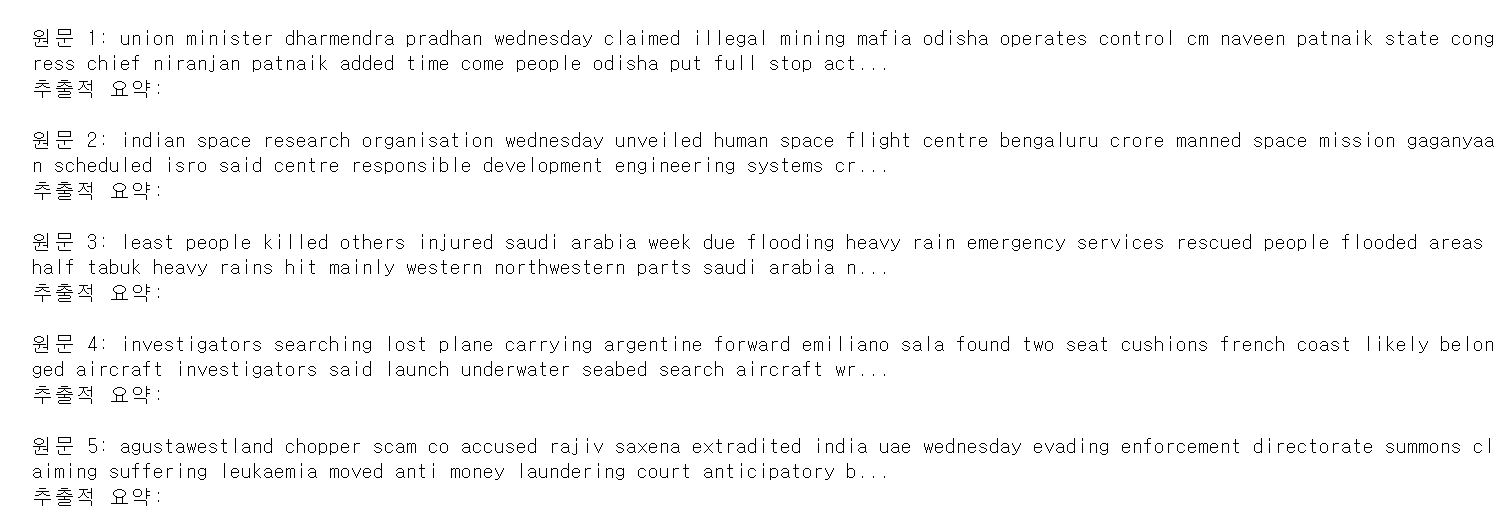

In [38]:
# sumy 라이브러리 사용 예시
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

def sumy_summary(text, sentences_count=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return " ".join(str(sentence) for sentence in summary)
# ratio 값을 높여서 더 많은 텍스트 포함
summary = summarize(sample_text, words=50)
print("단어 수 지정 요약:", summary)
# split=True 사용해서 리스트로 반환
summary_list = summarize(sample_text, ratio=0.2, split=True)
if summary_list:
    print("추출적 요약:", " ".join(summary_list))
else:
    print("추출적 요약: (비어있음)")


단어 수 지정 요약: agustawestland chopper scam co accused rajiv saxena extradited india.
uae wednesday evading enforcement directorate summons claiming suffering leukaemia moved anti money laundering court anticipatory bail.
december stating never summoned dubai address saxena lawyers alleged illegally extradited
추출적 요약: (비어있음)


추출적 요약이 비어있는걸 확인했다
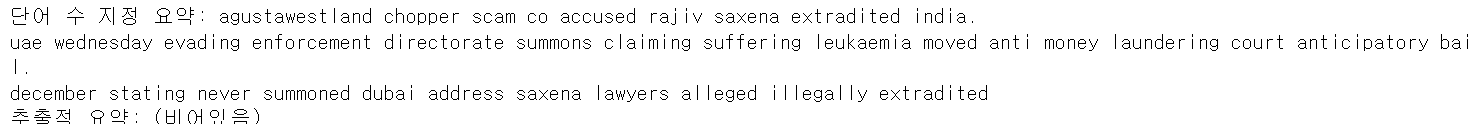

In [40]:
from summa.summarizer import summarize

# 50단어 이내로 요약
for i in range(5):
    summary = summarize(text, words=50)
    print(summary)
for i in range(5):
    summary = summarize(text, words=30)
    print(summary)
for i in range(5):
    summary = summarize(text, words=10)
    print(summary)

Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.
Morpheus and Neo are walking down a standard city street in what appears to be t

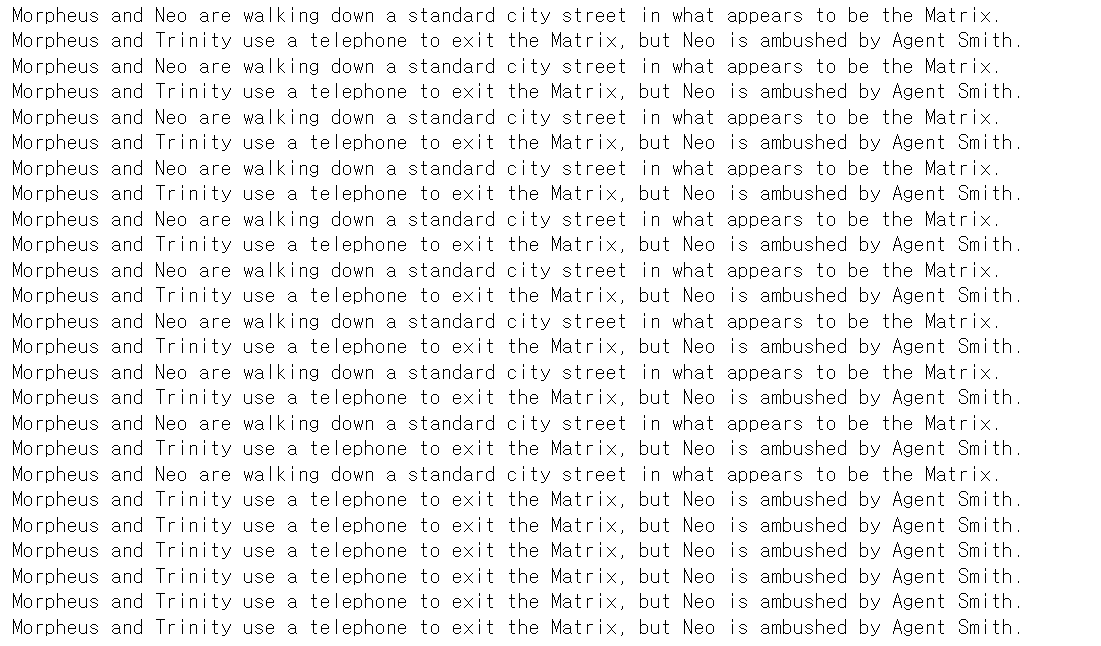
같은게 계속 나온다

In [43]:
from summa.summarizer import summarize

# 본문 텍스트만으로 요약
summary = summarize(text, ratio=0.05)         # 비율로 요약
summary = summarize(text, words=30)          # 단어 수로 요약
summary = summarize(text, split=True)        # 리스트로 반환
print(summary)


['A woman named Trinity is observing Neo, and she does so knowing that Morpheus believes that Neo is "the One".', "Notices about a manhunt for a man named Morpheus scroll across Neo's screen as he sleeps.", 'On the other end is Morpheus, who informs Neo that they\'ve both run out of time and that "they" are coming for him.', 'Three sinister Agents, led by Agent Smith (Hugo Weaving), come to arrest Neo and attempt to prevent him from collaborating with Morpheus.', "Morpheus guides Neo's escape by phone, able to somehow remotely observe their movements.", "Morpheus tries to guide Neo out of the building but when he is instructed to get on a scaffolding and take it to the roof Neo rejects Morpheus' advice, allowing himself to be taken by the Agents.", 'The Agents interrogate Neo about Morpheus, but he refuses to cooperate.', 'Morpheus tells Neo he is the One and to meet him at the Adams St. bridge.', 'Trinity and her allies bring Neo to Morpheus, their leader.', 'Undeterred, Neo meets wit

아직도 너무 길다.
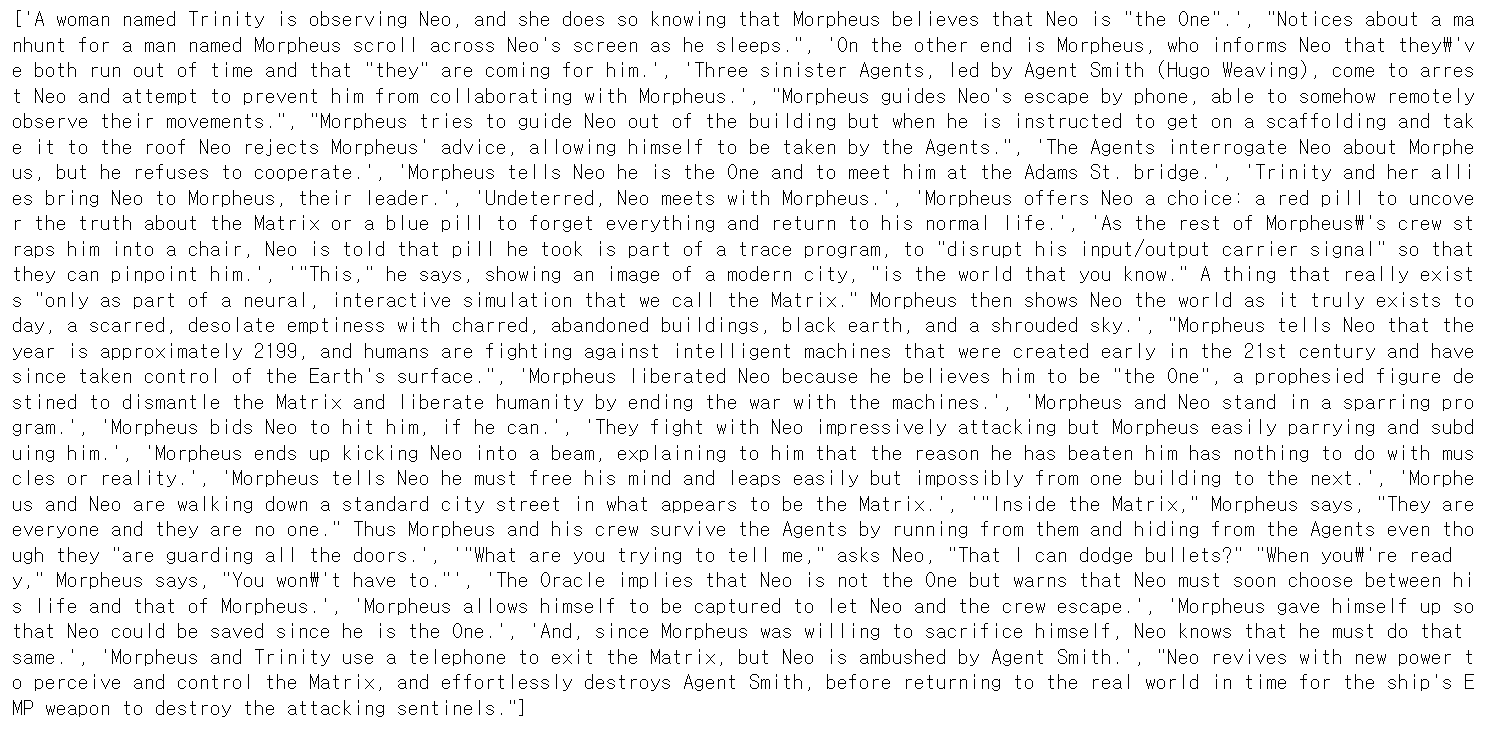

In [44]:
from summa.summarizer import summarize
from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(text)
ratio = 3 / len(sentences)
summary = summarize(text, ratio=ratio, split=True)
print('\n'.join(summary[:3]))


Morpheus and Neo are walking down a standard city street in what appears to be the Matrix.
Morpheus and Trinity use a telephone to exit the Matrix, but Neo is ambushed by Agent Smith.


최대3줄만 나오게 해주는게 제일 좋은 것 같다.
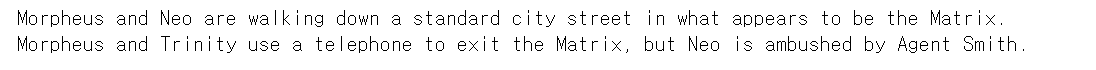

In [46]:
from summa.summarizer import summarize

def simple_sent_tokenize(text):
    # 마침표+공백으로 문장 분리 (nltk가 없을 때 대체)
    return text.split('. ')

# 내 데이터에서 5개 샘플 추출
sample_texts = data['text'].iloc[:5].tolist()

results = []

for i, sample_text in enumerate(sample_texts):
    sentences = simple_sent_tokenize(sample_text)
    ratio = 3 / len(sentences) if len(sentences) > 0 else 1
    summary = summarize(sample_text, ratio=ratio, split=True)
    results.append((i+1, '\n'.join(summary[:3])))

for idx, res in results:
    print(f"Sample {idx} 요약:\n{res}\n")


Sample 1 요약:


Sample 2 요약:


Sample 3 요약:


Sample 4 요약:


Sample 5 요약:




추출적 요약이 빈 결과값을 반환하는 이유
최소 3문장 이상의 텍스트가 필요

짧은 텍스트나 이미 요약된 텍스트에는 잘 작동하지 않음

문장 전체를 선택하기 때문에 문장 부분만 추출할 수 없음

어떻게 써야하나
추출적 요약은 주로 긴 문서에 적합합니다

명확한 문장 구분이 있는 텍스트에 가장 잘 작동합니다

빈 결과에 대한 폴백(fallback) 메커니즘을 항상 구현하세요

데이터 전처리를 통해 문장 구분을 명확히 해주세요

함수를 만들어서 사용하는 이유
재사용성:
여러 곳에서 추출적 요약을 호출할 때 일관된 인터페이스 제공

유지보수 편의성:
나중에 요약 비율(ratio)이나 단어 수(words) 등 파라미터를 쉽게 조정 가능

확장성:
필요하면 전처리, 후처리, 로깅 등 추가 기능을 함수 내에 넣을 수 있음

바로 전에 했던 코드와 다르게 어텐션을 써서 모델이 조금 더 성능이 좋아진 것 같고,
추상적 요약과 추측적요약의 차이점을 알 수 있어 좋았다.

추출적 요약은 원문에서 "중요 문장"을 그대로 복사해오므로,
결과가 항상 완성된 문장 형태로 나옵니다

추상적 요약은 원문의 의미를 파악해 새로운 문장을 만들어내는데,
이 과정에서 원문에 없는 단어, 표현, 심지어 완전히 새로운 요약문이 만들어질 수 있습니다